# Klassifizierung von Fahrzeugtypen
<br>
<br>

## Dataset

Z. Luo et. al. 2018. **MIO-TCD**: A New Benchmark Dataset for Vehicle Classification and Localization. Retrieved from https://ieeexplore.ieee.org/abstract/document/8387876
<br>
<br>
<br>

### Verwendeten Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Ordner Struktur

```
root 
│
└───test/
│   │   XXXXXXXXXX.jpg
│   │   ...
│   
└───train/
    │ 
    └───articulated_truck/
    │   │   0000000001.jpg
    │   │   0000000002.jpg
    │   │   ...
    │
    └───background/
    │   │   ...
    │
    └───...
```

### Metriken

- Es wurden **519K** Bilder gefunden die sich **11** Klassen zuordnen lassen.

- Davon wurden **77K** Bileder für das training verwendet.

- Und **51K** Bilder für die Validierung.

- Abmaße zwischen 342 × 228 und 720 × 480 pixeln

![Klassen](prsentation_materials/MIO_TCD_Classes.png "Klassen")

<br><br>
### Erstellung eines Datasets für das Training

Die folgenden Parameter wurden verwendet

```
batch_size = 32
img_height = 256
img_width = 256
```

### Visualisierung von Samples

<img src="prsentation_materials/dataset_samples.png" alt="Samples" style="width:500px;"/>

- Jeder `image_batch` ist ein Tensor der Form (32, 256, 256, 3)
- Dies ist ein Stapel von 32 Bildern der Form 256x256x3
- Dabei ist die letzte Dimension ein der RGB Farbkanal

## Standarisierung der Bilder

Die Werte des RGB Farbkanals liegen zwischen 0 und 255. Dies ist nicht ideal für das Neuronale Netzwerk und deshalb werden werden die Werte auf eine Range von 0 bis 1 standerdisiert

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

### Unser Model

- Das model besteht aus **3 Convolutional Layern** mit jeweils einem **MaxPooling Layer** (down sampling) dahinter
- Am Ende sitz ein voll verbundene Layer mit 128 Einheiten der durch eine **Relu Funktion** aktiviert wird

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Kompilierung des models

Verwendet wurde der **Adam** optimizer and **SparseCategoricalCrossentropy** loss function

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Zusammenfassung des Models

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
=================================================================
Total params: 8,413,739
Trainable params: 8,413,739
Non-trainable params: 0
_________________________________________________________________
```

## Training des Models

In [24]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2434/2434 [==============================] - 168s 63ms/step - loss: 0.6270 - accuracy: 0.8089 - val_loss: 0.4697 - val_accuracy: 0.8492
Epoch 2/10
2434/2434 [==============================] - 151s 62ms/step - loss: 0.3738 - accuracy: 0.8803 - val_loss: 0.4479 - val_accuracy: 0.8587
Epoch 3/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.2287 - accuracy: 0.9252 - val_loss: 0.5384 - val_accuracy: 0.8614
Epoch 4/10
2434/2434 [==============================] - 151s 62ms/step - loss: 0.1365 - accuracy: 0.9549 - val_loss: 0.7097 - val_accuracy: 0.8549
Epoch 5/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0929 - accuracy: 0.9701 - val_loss: 0.7814 - val_accuracy: 0.8579
Epoch 6/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0674 - accuracy: 0.9784 - val_loss: 0.9043 - val_accuracy: 0.8619
Epoch 7/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0562 - accuracy: 0.9814 - val_loss: 0

**Abschluss mit einer Validation Accuracy von 86%**

### History
<img src="prsentation_materials/model_training.png" alt="Model Training" style="width:500px;"/>

### Paper Ergebnisse
![Results](prsentation_materials/MIO_TCD_Results.png "Results")

<br>
<br>
<br>

## Klassifzierung eines Autos

### Vorrausgesetze Bibliotheken

In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__

'2.4.1'

In [3]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('saved_models/vehicle_model.h5')

class_names = ['Articulated Truck', 'Background', 'Bicycle', 'Bus', 'Car', 'Motorcycle', 'Non Motorized Vehicle', 'Pedestrian', 'Pickup Truck', 'Single Unit Truck', 'Work Van']

def predict_image(x):
    """predict a given image"""
    
    img = tf.keras.preprocessing.image.smart_resize(x, (256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return (class_names[np.argmax(score)], round(100 * np.max(score), 2))

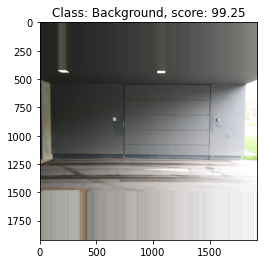

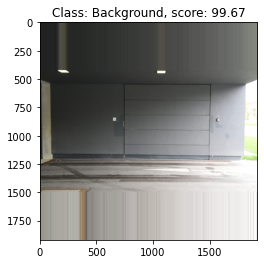

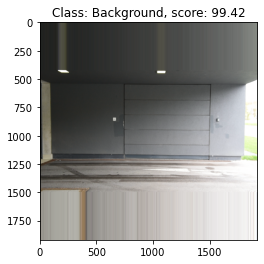

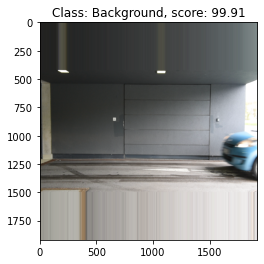

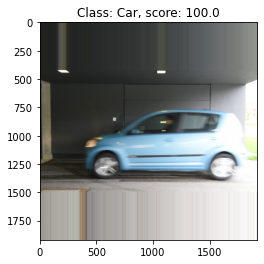

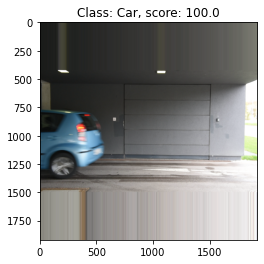

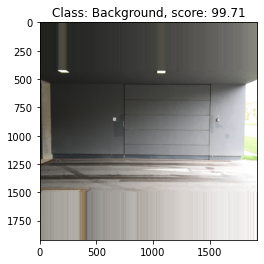

In [4]:
cap = cv2.VideoCapture('datasets/daihatsu_side_short.MOV') # capture
count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        count += 20 # i.e. at 30 fps, this advances one second

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # frame shape = 1920x1080x3

        # add padding -> 1920x1920x3
        img = cv2.copyMakeBorder(frame, 420, 420, 0, 0, cv2.BORDER_REPLICATE)

        cls, score = predict_image(img) # predict frame

        # display image
        plt.imshow(img)
        plt.title(f'Class: {cls}, score: {score}')
        plt.show()
        
        cap.set(1, count) # advance by 30 fps
    else:
        cap.release()
        break

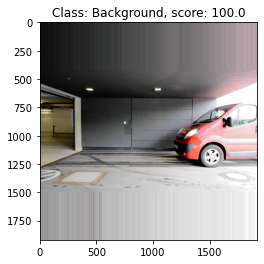

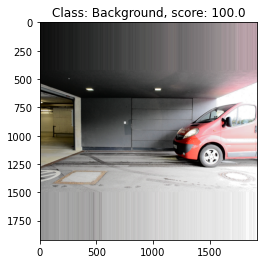

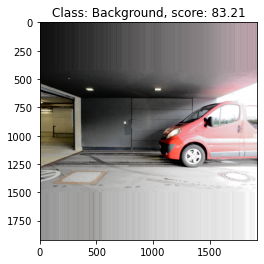

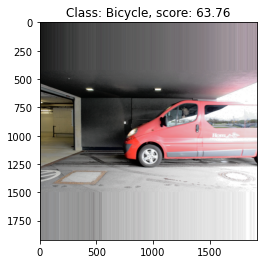

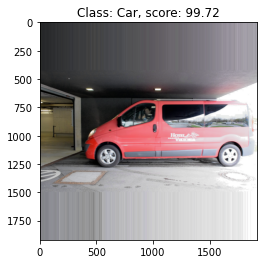

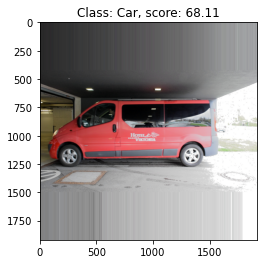

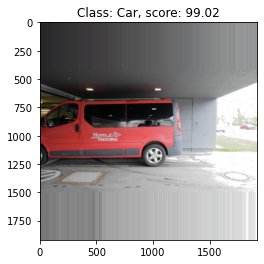

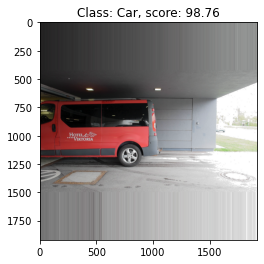

In [5]:
cap = cv2.VideoCapture('datasets/opel_side.MOV') # capture
count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        count += 30 # i.e. at 30 fps, this advances one second
        
        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)

        # equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # convert the YUV image back to RGB format
        frame = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

        # frame shape = 1920x1080x3
        # add padding -> 1920x1920x3
        img = cv2.copyMakeBorder(frame, 420, 420, 0, 0, cv2.BORDER_REPLICATE)

        cls, score = predict_image(img) # predict frame

        # display image
        plt.imshow(img)
        plt.title(f'Class: {cls}, score: {score}')
        plt.show()
        
        cap.set(1, count) # advance by 30 fps
    else:
        cap.release()
        break

## Regelbasierte Klassifizierung

In [15]:
from scipy.signal import find_peaks

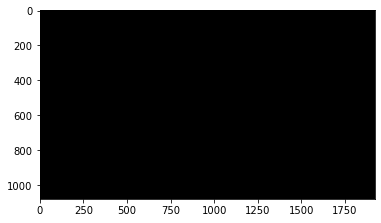

There are 0 set to 255


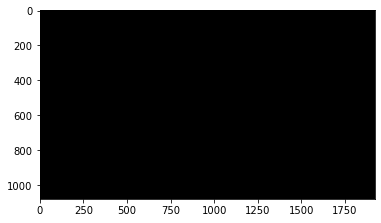

There are 0 set to 255


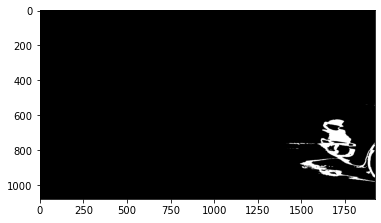

There are 35908 set to 255


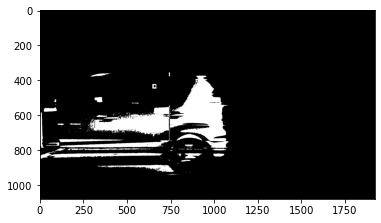

There are 159967 set to 255


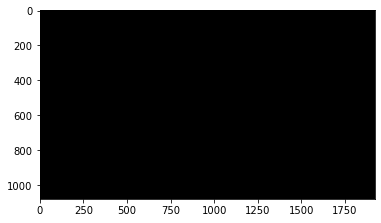

There are 0 set to 255


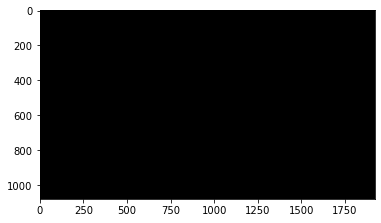

There are 0 set to 255


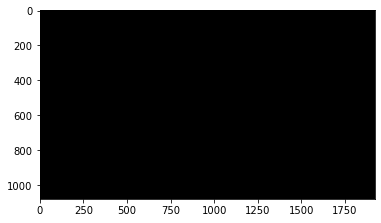

There are 0 set to 255


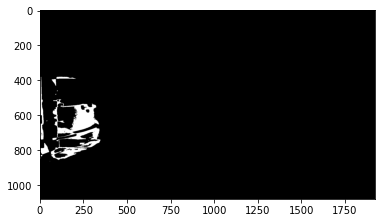

There are 42814 set to 255


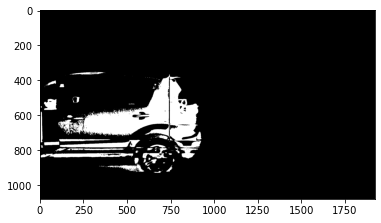

There are 168842 set to 255


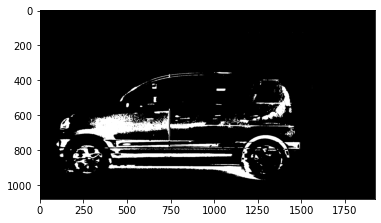

There are 142566 set to 255


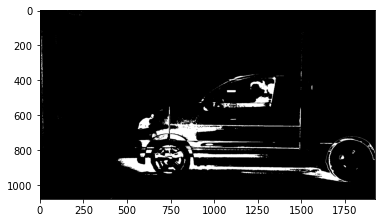

There are 106705 set to 255


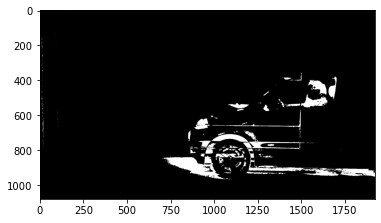

There are 86879 set to 255


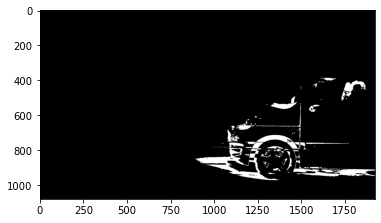

There are 67630 set to 255


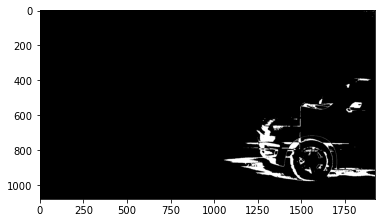

There are 53628 set to 255


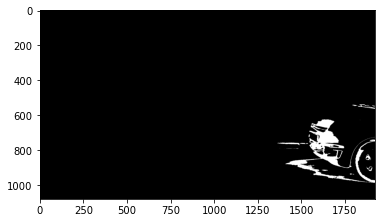

There are 38665 set to 255


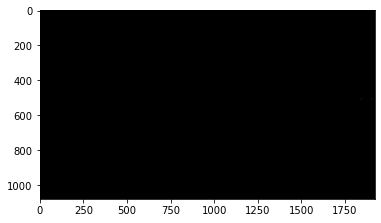

There are 11 set to 255


In [6]:
bg_car_threshold = 55

cap = cv2.VideoCapture('datasets/daihatsu_side.MOV') # capture


count = 0 # frames passed
index = 0 # iteration
bg = None # Background for substraction

x = [] # frames
y = [] # save results for every iteration

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        count += 30 # i.e. at 30 fps, this advances one second
        
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to gray
        img = cv2.cv2.equalizeHist(img) # Equalize Histogram

        if bg is None:
            bg = img # start of the video set background

        # difference between background and frame
        img_diff = bg + bg_car_threshold - img

        (T, thresh) = cv2.threshold(img_diff, 180, 255, cv2.THRESH_BINARY)
        # display image
        plt.imshow(thresh, cmap='gray')
        plt.show()
        # count non zero pixels
        nonzero = np.count_nonzero(thresh)
        print(f'There are {nonzero} set to 255')

        if nonzero == 0:
            bg = img

        # save values for plotting
        x.append(count)
        y.append(nonzero)
        
        cap.set(1, count) # advance by 30 fps
        index += 1 # add to index
    else:
        cap.release()
        break

### Darstellung der Ergebisse

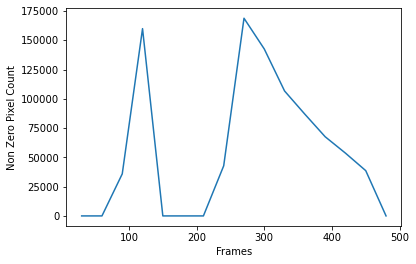

In [19]:
plt.plot(x, y)
plt.ylabel('Non Zero Pixel Count')
plt.xlabel('Frames')
plt.show()

### Interpretierung des Diagrams mit scipy

In [18]:
peaks, _ = find_peaks(y) # Number of maximas

print(f'{len(peaks)} vehicles have passed through the screen')
for index, peak in enumerate(peaks):
    value = y[peak]
    if value > 125e3 and value <= 180e3:
        print(f'The {index + 1} vehicle must have been a small car')
    if value > 180e3 and value <= 210e3:
        print(f'The {index + 1} vehicle must have been a car')
    if value > 210e3:
        print(f'The {index + 1} vehicle must have been a van')

2 vehicles have passed through the screen
The 1 vehicle must have been a small car
The 2 vehicle must have been a small car


# Danke für eure Aufmerksamkeit

Ihr findet das Projekt auf github: https://github.com/konstantin-paulus/computer-vision-vehicle-classification